## Phase locking/phase coherence
Questions: 
* Does TMS increase inter-trial coherence? In which frequency bands?
* Do electrodes that show real-time increases in phase locking also show increases in functional connectivity from before/after TMS session?

In [1]:
import numpy as np
import mne
import pandas as pd
import pylab as plt

# For custom codebase
import sys
sys.path.insert(0, 'C:\\Users\\esolo\\Documents\\Python Scripts\\lib')

# For parallel processing
import multiprocessing as mp
n_cpus = mp.cpu_count()

In [2]:
# Grab the full set of subjects and sessions to use
root = 'D:/'  # root directory for saved data
master = pd.read_csv(root+'master.csv')
sub_list = master['subject'].unique()

### Visualize some ITCs

In [155]:
import pycircstat as circ
from glob import glob

# Set some params
sub = '477'
target = 'L_DLPFC'
freqs = [3, 4, 5, 6, 7, 8] 
n_cycles = 2

#Load the data
dirs = glob(root+str(sub)+'/*/')        
fname = root+str(sub)+'/complete_epo.fif'
epochs = mne.read_epochs(fname, preload=True, verbose=False)
elecs = pd.read_pickle(dirs[0]+'contacts.pkl')   
fs = epochs.info['sfreq']

# Load theta power information for easy correlations w/ power information
power_df = pd.read_pickle('./multitaper_power_0.5_1.5_3-8Hz.pkl')
power_subdf = power_df[(power_df['subject']==sub) & (power_df['target']==target)]

epochs = epochs[epochs.metadata['target'].str.contains(target)]

from mne.time_frequency import tfr_array_multitaper
tms_dat = epochs['tms'].get_data()
sham_dat = epochs['sham'].get_data()

#Add mirror buffers (better than nothing but can induce some spectral changes)
mirror_size = 225
tms_mirror = np.concatenate((np.flip(tms_dat[:, :, :mirror_size], axis=2), tms_dat, np.flip(tms_dat[:, :, -mirror_size:], axis=2)), axis=2)  #Using 450ms buffers
sham_mirror = np.concatenate((np.flip(sham_dat[:, :, :mirror_size], axis=2), sham_dat, np.flip(sham_dat[:, :, -mirror_size:], axis=2)), axis=2)

# Get TFR of phase from the TMS trials
tfr_tms = mne.time_frequency.tfr_array_multitaper(tms_mirror, 
                                                  sfreq=fs, freqs=freqs, output='phase',
                                                  n_cycles=n_cycles, n_jobs=n_cpus)

# Now for the sham trials
tfr_sham = mne.time_frequency.tfr_array_multitaper(sham_mirror,
                                                   sfreq=fs, freqs=freqs, output='phase',
                                                  n_cycles=n_cycles, n_jobs=n_cpus) # output is trials x elecs x tapers x frequencies x times

# Clip the buffers
tfr_tms = tfr_tms[:, :, :, :, mirror_size:-mirror_size]
tfr_sham = tfr_sham[:, :, :, :, mirror_size:-mirror_size]

#Average phase across tapers
tfr_tms = circ.mean(tfr_tms, axis=2) 
tfr_sham = circ.mean(tfr_sham, axis=2)

# Compute phase locking
rlv_tms = circ.resultant_vector_length(tfr_tms, axis=0)
rlv_sham = circ.resultant_vector_length(tfr_sham, axis=0)  #output is elecs x frequencies x time

# Average into band-level results (must do AFTER PLV computation)
tms_band = np.nanmean(rlv_tms, axis=1); sham_band = np.nanmean(rlv_sham, axis=1)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 108 tasks      | elapsed:    6.9s
[Parallel(n_jobs=4)]: Done 139 out of 139 | elapsed:    7.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 139 out of 139 | elapsed:   16.0s finished


**Do a quick correction for differential number of trials by subsampling the one with higher N (usually sham)**

In [65]:
# Or just load the data directly
sub = '518'; target = 'DLPFC'
tms_band = np.load(root+'TMS_iEEG_PLV/'+sub+'/'+target+'/tms_band_resamp.npy')
sham_band = np.load(root+'TMS_iEEG_PLV/'+sub+'/'+target+'/sham_band_resamp.npy')
tms_band_orig = np.load(root+'TMS_iEEG_PLV/'+sub+'/'+target+'/tms_band_orig.npy')
sham_band_orig = np.load(root+'TMS_iEEG_PLV/'+sub+'/'+target+'/sham_band_orig.npy')
plv_diff = np.load(root+'TMS_iEEG_PLV/'+sub+'/'+target+'/plv_diff.npy')
tfr_tms = np.load(root+'TMS_iEEG_PLV/'+sub+'/'+target+'/tfr_tms.npy')
power_subdf = pd.read_pickle(root+'TMS_iEEG_PLV/'+sub+'/'+target+'/power_dataframe.pkl')

In [66]:
# Find electrodes with (roughly) significant increase in ITC over sham
print(np.unique(np.where(plv_diff[:, 500:]>0.2)[0]))

[  3   4  21  30  34  36  42  52  61  70  71  74  77  78  79  80  81  82
  84  86  87  88  89  90  91  92  95  97 101 102 105 114 115 123 124 126
 127 131 132 134 136 137 141 143 154 155 156 158 164 165 166 170 172 173
 175 179 180 186 187]


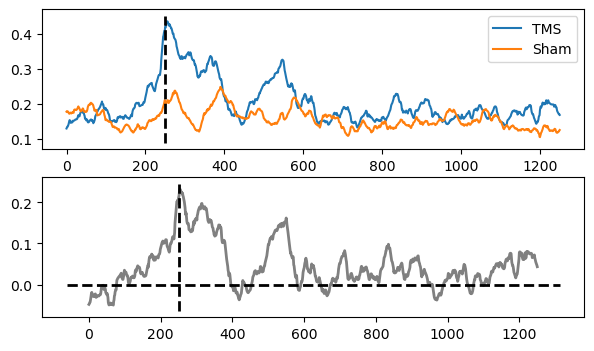

In [67]:
# Plot early results
e = 0

plt.figure(figsize=(7, 4)); ax=plt.subplot(211)
plt.plot(tms_band[e, :], label='TMS'); plt.plot(sham_band[e, :], label='Sham')
plt.vlines([250], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyle='--', linewidth=2, color='k')
plt.legend()

ax=plt.subplot(212)
plt.plot(plv_diff[e, :], color='gray', linewidth=2)
plt.vlines([250], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyle='--', linewidth=2, color='k')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='--', linewidth=2, color='k')

# plt.figure(figsize=(7, 2)); ax=plt.subplot(111)
# plt.plot(tms_dat[:, e, :].T, alpha=0.4, linewidth=0.3, color='gray');
# plt.title('Sample EEG')

- Sub 405, STG stim, electrode index 111 has some nice ITC increase. 
- Sub 460, DLPFC stim, electrode 6 shows nice ITC increase. 
- Sub 404, Motor stim, electrode 184

Probably need to do some kind of baseline subtraction for these data, too. Not that the effect of increasing overall PLV throughout a session is unimportant. (Likely will want to include that as a result, anyway.)

Since the pre-stim interval is so short (500ms), might be better to use the end of the interval as a baseline which risks less contamination?

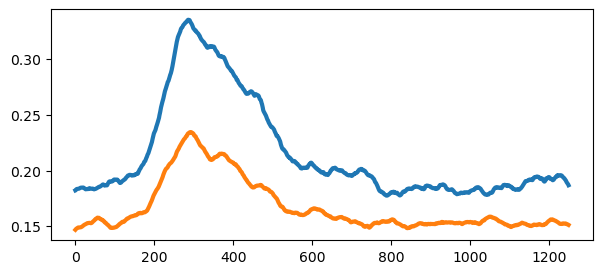

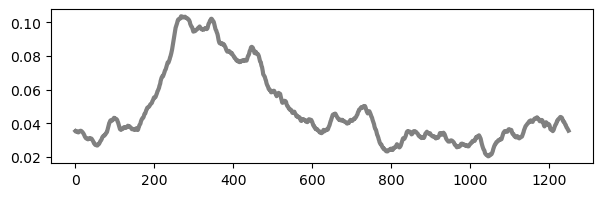

In [71]:
plt.figure(figsize=(7, 3)); ax=plt.subplot(111)
good_elecs = np.where(np.sum(power_subdf[['noisy', 'saturated']], 1)==0)[0]

# plt.plot(tms_band[good_elecs, :].T, color='C0', linewidth=0.5, alpha=0.3);
# plt.plot(sham_band[good_elecs, :].T, color='C1', linewidth=0.5, alpha=0.3);

plt.plot(np.nanmean(tms_band[good_elecs, :], 0), color='C0', linewidth=3)
plt.plot(np.nanmean(sham_band[good_elecs, :], 0), color='C1', linewidth=3)

plt.figure(figsize=(7, 2)); ax=plt.subplot(111)
plt.plot(np.nanmean(tms_band[good_elecs, :]-sham_band[good_elecs, :], 0), color='gray', linewidth=3)
#plt.plot(tms_band[good_elecs, :].T-sham_band[good_elecs, :].T, color='gray', alpha=0.2, linewidth=0.5); 

### Baseline subtraction

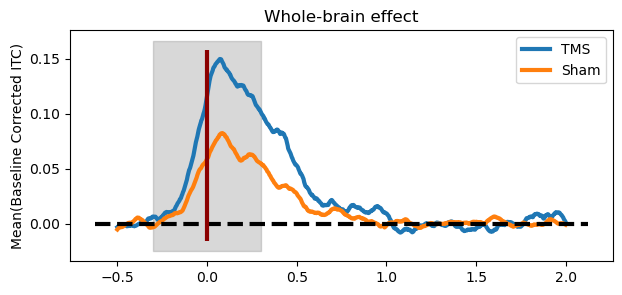

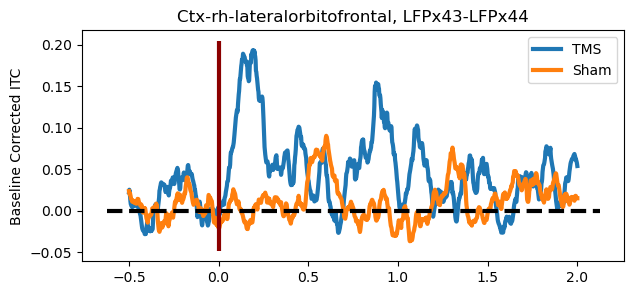

In [87]:
tms_base_cr = tms_band-np.tile(np.reshape(np.mean(tms_band[:, :100], axis=1), (-1, 1)), (1, tms_band.shape[1]))  # baseline correct against first 200ms
sham_base_cr = sham_band-np.tile(np.reshape(np.mean(sham_band[:, :100], axis=1), (-1, 1)), (1, sham_band.shape[1]))

X = (np.arange(0, 1251)/500)-0.5
plt.figure(figsize=(7, 3)); ax=plt.subplot(111)
plt.plot(X, np.nanmean(tms_base_cr[good_elecs, :], 0), color='C0', linewidth=3, label='TMS')
plt.plot(X, np.nanmean(sham_base_cr[good_elecs, :], 0), color='C1', linewidth=3, label='Sham')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linewidth=3, linestyle='--', color='k')
plt.vlines([0], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linewidth=3, linestyle='-', color='darkred')
plt.fill_between([-0.3, 0.3], y1=ax.get_ylim()[0], y2=ax.get_ylim()[1], color='gray', alpha=0.3)
plt.ylabel('Mean(Baseline Corrected ITC)')
plt.title('Whole-brain effect')
plt.legend()

#plt.figure(figsize=(7, 2)); ax=plt.subplot(111)
#plt.plot(np.nanmean(tms_base_cr[good_elecs, :]-sham_base_cr[good_elecs, :], 0), color='gray', linewidth=3)
elec = 14; elec_info = power_subdf.iloc[good_elecs[elec]];
plt.figure(figsize=(7, 3)); ax=plt.subplot(111)
plt.plot(X, tms_base_cr[good_elecs[elec], :], color='C0', linewidth=3, label='TMS')
plt.plot(X, sham_base_cr[good_elecs[elec], :], color='C1', linewidth=3, label='Sham')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linewidth=3, linestyle='--', color='k')
plt.vlines([0], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linewidth=3, linestyle='-', color='darkred')
plt.title(str(elec_info['DKT_label'])+', '+str(elec_info['channel_name']))
plt.ylabel('Baseline Corrected ITC')
plt.legend()


- Subject 405, Parietal stim, electrode LFPx238, x243, x246, x247 (good_elec 72) is a decent example of +theta ITC in the TMS trials (maybe apply some smoothing)
- Subject 483, L_DLPFC stim, electrode LFPx18-19, LFPx22-193
- Subject 430, DLPFC stim, electrode LFPx8-LFPx9 (good elec 8) 

#### Region-specific effects

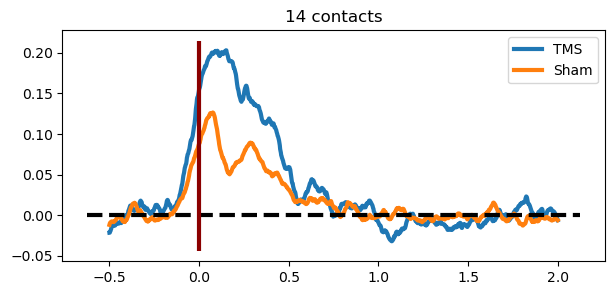

In [106]:
from codebase import filter_dict

# Find region of interest
idxs = power_subdf[power_subdf['DKT_label'].str.contains(filter_dict['limbic_filter']) & (power_subdf['noisy']==False) & (power_subdf['saturated']==False)]
first_index = power_subdf.index[0]
corrected_indexes = idxs.index-first_index  # necessary to re-set indices to starting at zero for proper alignment 

# Examine timecourses for specific region
plt.figure(figsize=(7, 3)); ax=plt.subplot(111)
X = (np.arange(0, 1251)/500)-0.5
plt.plot(X, np.nanmean(tms_base_cr[corrected_indexes, :], 0), color='C0', linewidth=3, label='TMS')
plt.plot(X, np.nanmean(sham_base_cr[corrected_indexes, :], 0), color='C1', linewidth=3, label='Sham')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linewidth=3, linestyle='--', color='k')
plt.vlines([0], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linewidth=3, linestyle='-', color='darkred')
plt.title(str(len(idxs))+' contacts')
plt.legend()

Can we examine **change in PLV over trials**? Difficult, because PLV is an across-trial measure. Could take every 10 trials or something like that?

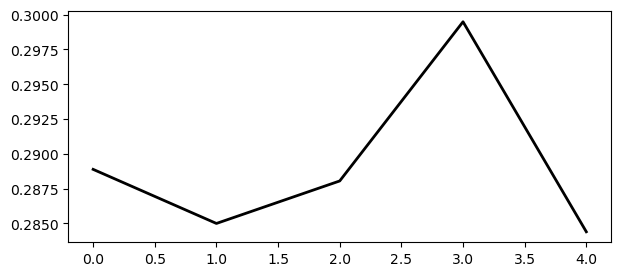

In [170]:
step = 10
step_rlv = []
for i in range(0, 50, 10):
    step_rlv.append(np.nanmean(np.nanmean(circ.resultant_vector_length(tfr_tms[i:i+step, :, :, 500:1000], axis=0), axis=1), axis=1))
step_rlv = np.array(step_rlv)  # ends up with step x electrode dimensions

plt.figure(figsize=(7, 3)); ax=plt.subplot(111)
#plt.plot(step_rlv, '-', color='gray', alpha=0.25);
plt.plot(np.nanmean(step_rlv, 1), color='black', linewidth=2)

### Analyze across subjects

In [3]:
import os
import pandas as pd
import numpy as np
import pycircstat as circ
import mne
from glob import glob

# Set some params
freqs = [3, 4, 5, 6, 7, 8] 
n_cycles = 2
mirror_size = 225
numshuf = 10
power_df = pd.read_pickle('./multitaper_power_0.5_1.5_3-8Hz.pkl')

for sub in sub_list[:]:
    
    sessions = np.unique(master[master['subject']==sub]['target'])
    
    for sess in sessions:
        
        subroot = root+'TMS_iEEG_PLV/'+sub+'/'+sess+'/'
        
        try:
            # Create directory for outputs
            try:
                os.mkdir(root+'TMS_iEEG_PLV/'+sub+'/')
            except:
                # directory already exists
                pass
            
            try:
                os.mkdir(subroot)
            except:
                # directory already exists
                pass
            
            #Load the data
            dirs = glob(root+str(sub)+'/*/')        
            fname = root+str(sub)+'/complete_epo.fif'
            epochs = mne.read_epochs(fname, preload=True, verbose=False)
            elecs = pd.read_pickle(dirs[0]+'contacts.pkl')   
            fs = epochs.info['sfreq']

            epochs = epochs[epochs.metadata['target'].str.contains(sess)]
            
            # Load theta power information for easy correlations w/ power information
            power_subdf = power_df[(power_df['subject']==sub) & (power_df['target']==sess)]
            power_subdf.to_pickle(subroot+'power_dataframe.pkl')

            from mne.time_frequency import tfr_array_multitaper
            tms_dat = epochs['tms'].get_data()
            sham_dat = epochs['sham'].get_data()

            #Add mirror buffers (better than nothing but can induce some spectral changes)
            tms_mirror = np.concatenate((np.flip(tms_dat[:, :, :mirror_size], axis=2), tms_dat, np.flip(tms_dat[:, :, -mirror_size:], axis=2)), axis=2)  #Using 450ms buffers
            sham_mirror = np.concatenate((np.flip(sham_dat[:, :, :mirror_size], axis=2), sham_dat, np.flip(sham_dat[:, :, -mirror_size:], axis=2)), axis=2)

            # Get TFR of phase from the TMS trials
            tfr_tms = mne.time_frequency.tfr_array_multitaper(tms_mirror, 
                                                              sfreq=fs, freqs=freqs, output='phase',
                                                              n_cycles=n_cycles, n_jobs=n_cpus)

            # Now for the sham trials
            tfr_sham = mne.time_frequency.tfr_array_multitaper(sham_mirror,
                                                               sfreq=fs, freqs=freqs, output='phase',
                                                              n_cycles=n_cycles, n_jobs=n_cpus) # output is trials x elecs x tapers x frequencies x times

            # Clip the buffers
            tfr_tms = tfr_tms[:, :, :, :, mirror_size:-mirror_size]
            tfr_sham = tfr_sham[:, :, :, :, mirror_size:-mirror_size]

            #Average phase across tapers
            tfr_tms = circ.mean(tfr_tms, axis=2) 
            tfr_sham = circ.mean(tfr_sham, axis=2)
            np.save(subroot+'tfr_tms.npy', tfr_tms)
            np.save(subroot+'tfr_sham.npy', tfr_sham)

            # Compute phase locking
            rlv_tms = circ.resultant_vector_length(tfr_tms, axis=0)
            rlv_sham = circ.resultant_vector_length(tfr_sham, axis=0)  #output is elecs x frequencies x time

            # Average into band-level results (must do AFTER PLV computation)
            tms_band = np.nanmean(rlv_tms, axis=1); sham_band = np.nanmean(rlv_sham, axis=1)
            np.save(subroot+'tms_band_orig.npy', tms_band)
            np.save(subroot+'sham_band_orig.npy', sham_band)
            
            # Correct for differing number of trials between sham and TMS
            minN = np.min([tfr_tms.shape[0], tfr_sham.shape[0]])
            maxArr = np.argmax([tfr_tms.shape[0], tfr_sham.shape[0]])  # order here matters

            rlv_resamp_sham = []
            rlv_resamp_tms = []

            for i in range(numshuf):
                rlv_resamp_sham.append(circ.resultant_vector_length(tfr_sham[np.random.randint(0, tfr_sham.shape[0], size=minN), :, :, :], axis=0))
                rlv_resamp_tms.append(circ.resultant_vector_length(tfr_tms[np.random.randint(0, tfr_tms.shape[0], size=minN), :, :, :], axis=0))
            rlv_sham_cr = np.mean(np.array(rlv_resamp_sham), axis=0)
            rlv_tms_cr = np.mean(np.array(rlv_resamp_tms), axis=0)

            tms_band = np.nanmean(rlv_tms_cr, axis=1); 
            sham_band = np.nanmean(rlv_sham_cr, axis=1);
            plv_diff = tms_band-sham_band
            
            np.save(subroot+'tms_band_resamp.npy', tms_band)
            np.save(subroot+'sham_band_resamp.npy', sham_band)
            np.save(subroot+'plv_diff.npy', plv_diff)
            
        except:
            continue

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  64 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done  79 out of  79 | elapsed:    5.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  64 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done  79 out of  79 | elapsed:    5.4s finished


### Perform population-level statistics

In [14]:
def get_stim_side(t_sub):
    stim_side = []
    for idx in range(len(t_sub)):
        myside='None'
        if t_sub['target_x'].iloc[idx]<0:
            myside='Left'
        elif t_sub['target_x'].iloc[idx]>0:
            myside='Right'
        elif t_sub['target'].iloc[idx][0]=='R':
            myside='Right'
        elif t_sub['target'].iloc[idx][0]=='L':
            myside='Left'
        else:
            # Can do this final check if only one side is sampled at all (only necessary for subject 622)
            if len(t_sub['Side'].unique())==1:
                myside=t_sub['Side'].iloc[0]
        stim_side.append(myside)
    stim_side = np.array(stim_side)
    
    return stim_side

In [15]:
itc_pd = pd.DataFrame(columns=['subject', 'target', 'mean_itc_tms', 'mean_itc_sham', 'mean_itc_diff', 'itc_start_samp', 'itc_end_samp', 'channel_name', 'elec_idx', 
                     'power_T', 'noisy', 'saturated', 'target_distance', 'distance_category', 'DKT_label'])
power_df = pd.read_pickle('./multitaper_power/multitaper_power_0.05_0.55_3-8Hz.pkl')  # the spectral power database for all electrodes

for itc_start_samp in np.arange(275, 525, 50):
    
    itc_end_samp = itc_start_samp+250;
    # Starting at sample 650 and running 250 samples would equate to starting at the 800ms post-stim timepoint, or 300ms following the
    # last reasonable ERP (e.g. 500ms post-stim). 

    for sub in sub_list[:]:
        sessions = np.unique(master[master['subject']==sub]['target'])
        for sess in sessions:

            try:
                # Load the data
                subroot = root+'TMS_iEEG_PLV/'+sub+'/'+sess+'/'
                power_subdf = power_df[(power_df['subject']==sub) & (power_df['target']==sess)]
                tms_band = np.load(subroot+'tms_band_resamp.npy')
                sham_band = np.load(subroot+'sham_band_resamp.npy')

                # Baseline correct the data
                tms_base_cr = tms_band-np.tile(np.reshape(np.mean(tms_band[:, :100], axis=1), (-1, 1)), (1, tms_band.shape[1]))  # baseline correct against first 200ms
                sham_base_cr = sham_band-np.tile(np.reshape(np.mean(sham_band[:, :100], axis=1), (-1, 1)), (1, sham_band.shape[1]))

                diff_base_cr = tms_base_cr-sham_base_cr
                mean_itc_diff = np.mean(diff_base_cr[:, itc_start_samp:itc_end_samp], axis=1)
                mean_itc_tms = np.mean(tms_base_cr[:, itc_start_samp:itc_end_samp], axis=1)
                mean_itc_sham = np.mean(sham_base_cr[:, itc_start_samp:itc_end_samp], axis=1)

                myside = get_stim_side(power_subdf)[0]

                # Loops through electrodes
                for e_idx in range(tms_band.shape[0]):

                    itc_pd = pd.concat([itc_pd, pd.DataFrame({'subject': sub, 'target': sess, 'mean_itc_tms': mean_itc_tms[e_idx], 'mean_itc_sham': mean_itc_sham[e_idx],
                                                              'mean_itc_diff': mean_itc_diff[e_idx], 'start_time': (itc_start_samp/500.)-0.5, 'end_time': (itc_end_samp/500.)-0.5,
                                                             'channel_name': power_subdf.iloc[e_idx]['channel_name'], 'elec_idx': e_idx, 'power_T': power_subdf.iloc[e_idx]['T'],
                                                              'noisy': power_subdf.iloc[e_idx]['noisy'], 'saturated': power_subdf.iloc[e_idx]['saturated'],
                                                              'target_distance': power_subdf.iloc[e_idx]['target_distance'], 'distance_category': power_subdf.iloc[e_idx]['distance_category'], 
                                                              'DKT_label': power_subdf.iloc[e_idx]['DKT_label'], 'sense_side': power_subdf.iloc[e_idx]['Side'],
                                                             'stim_side': myside}, index=[0])], ignore_index=True)
            except:
                continue
            
# Filter out electrodes with noisy data
itc_pd = itc_pd[itc_pd['noisy']==False]; itc_pd = itc_pd[itc_pd['saturated']==False];

C:\Users\esolo\AppData\Local\Temp\ipykernel_20140\1740744103.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  l_frontal_filter = itc_pd['DKT_label'].str.contains('^Ctx-lh.*(frontal|parsopercu|parsorbi|paracentral|precentral|parstriang)')
C:\Users\esolo\AppData\Local\Temp\ipykernel_20140\1740744103.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  r_frontal_filter = itc_pd['DKT_label'].str.contains('^Ctx-rh.*(frontal|parsopercu|parsorbi|paracentral|precentral|parstriang)')
C:\Users\esolo\AppData\Local\Temp\ipykernel_20140\1740744103.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  l_temporal_filter = itc_pd['DKT_label'].str.contains('^Ctx-lh.*(temporal|fusiform|bankssts)')
C:\Users\esolo\AppData\Local\Temp\ipykernel_

Text(0.5, 1.0, '-0.59, 0.55648')

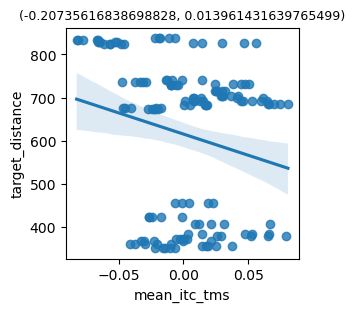

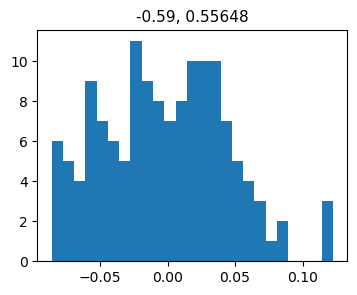

In [16]:
# Get some anatomic filters for sense electrode
l_frontal_filter = itc_pd['DKT_label'].str.contains('^Ctx-lh.*(frontal|parsopercu|parsorbi|paracentral|precentral|parstriang)')
r_frontal_filter = itc_pd['DKT_label'].str.contains('^Ctx-rh.*(frontal|parsopercu|parsorbi|paracentral|precentral|parstriang)')
l_temporal_filter = itc_pd['DKT_label'].str.contains('^Ctx-lh.*(temporal|fusiform|bankssts)')
r_temporal_filter = itc_pd['DKT_label'].str.contains('^Ctx-rh.*(temporal|fusiform|bankssts)')
l_mtl_filter = itc_pd['DKT_label'].str.contains('(^Ctx-lh.*(entorhinal|parahipp))|(^Left.*Hippocampus)')
r_mtl_filter = itc_pd['DKT_label'].str.contains('(^Ctx-rh.*(entorhinal|parahipp))|(^Right.*Hippocampus)')

# Filter the dataframe to particular stim site/sense electrodes
toplot = itc_pd[(itc_pd['target'].str.contains('DLPFC')) & (itc_pd['sense_side']=='Left') & (itc_pd['stim_side']=='Left') & (itc_pd['subject']=='430')]

import seaborn as sns
X = 'mean_itc_tms'; Y = 'target_distance'
plt.figure(figsize=(3, 3)); ax=plt.subplot(111)
sns.regplot(x=toplot[X], y=toplot[Y]**(1/0.7))   # taking a power to normalize transform the distance values
#plt.plot(toplot['mean_itc_diff'], toplot['target_distance'], '.', alpha=0.25);

from scipy.stats import pearsonr, ttest_1samp
plt.title(pearsonr(toplot[X], toplot[Y]**(1/0.7)), fontsize=9)

plt.figure(figsize=(4, 3)); ax=plt.subplot(111)
plt.hist(toplot['mean_itc_diff'], 25);
t, p = ttest_1samp(toplot['mean_itc_diff'], 0)  # run t-test on the mean differences
plt.title(str(np.round(t, 3))+', '+str(np.round(p, 5)), fontsize=11)

- Subject 538 has a significant negative correlation between target distance and phase locking within the left hemisphere (positive correlation on the right, but far fewer datapoints). 

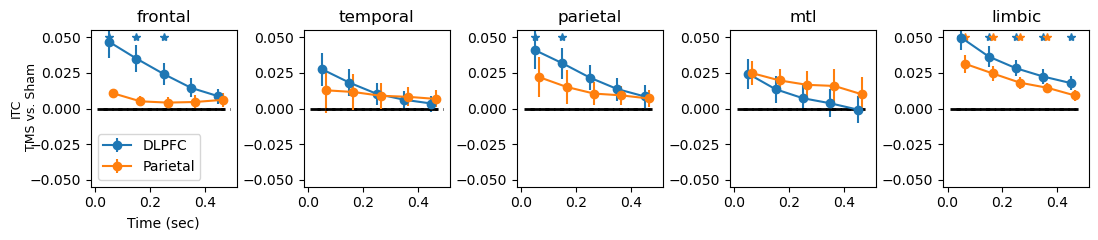

In [18]:
from scipy.stats import sem, ttest_1samp
from mne.stats import fdr_correction
from codebase import filter_dict

# Plot results by response region and stim area

plt.figure(figsize=(11, 2.5)); 
alpha = 0.05
x_shift = 0

# Loop through stim sites
for stim_site in [('Both', 'DLPFC'), ('Both', 'Parietal')]:
    
    c = 1; 

    if stim_site[0]=='Both':
        stim_subdf = itc_pd[itc_pd['target'].str.contains(stim_site[1])]
    else:
        stim_subdf = itc_pd[(itc_pd['target'].str.contains(stim_site[1])) & (itc_pd['stim_side'].str.contains(stim_site[0]))]
        
    if len(stim_subdf)==0:
        continue

    for sense_lobe in ['frontal', 'temporal', 'parietal', 'mtl', 'limbic']:

        s_region = stim_subdf[stim_subdf['DKT_label'].str.contains(filter_dict[sense_lobe+'_filter'])]
        
        mu = []; sem_ = []; X = []; t_ = []; p_ = []
        
        for s in s_region['start_time'].unique():
            X.append(s)
            mu.append(np.nanmean(s_region[s_region['start_time']==s].groupby('subject').mean()['mean_itc_diff']))
            sem_.append(sem(s_region[s_region['start_time']==s].groupby('subject').mean()['mean_itc_diff']))
            t, p = ttest_1samp(s_region[s_region['start_time']==s].groupby('subject').mean()['mean_itc_diff'], 0)
            t_.append(t); p_.append(p); 

        # Plot results
        X = np.array(X)
        ax=plt.subplot(1,5,c)
        line = plt.errorbar(np.array(X)+x_shift, mu, yerr=sem_, label=stim_site[1], marker='o')
        plt.plot(X[fdr_correction(p_, alpha)[0]]+x_shift, [0.05]*fdr_correction(p_, alpha)[0].sum(), marker='*', color=line[0].get_color(), linewidth=0)
        plt.title(sense_lobe.split('_')[0])
        plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='--', color='k', linewidth=2)
        plt.ylim(-0.055, 0.055)
        
        if c==1:
            plt.legend(loc=3)
            plt.xlabel('Time (sec)')
            plt.ylabel('ITC\n TMS vs. Sham', fontsize=9, va='center')
        
        c = c+1
        
    x_shift = x_shift+0.015

# Finish up plots    
plt.tight_layout()
#plt.savefig('./multitaper_epo_plots/ITC_theta_by_response_region.pdf')

# Analyze within-hemisphere responses to stimulation

sub_Rs = pd.DataFrame(columns=['subject', 'hemis', 'target', 'r_dist', 'p_dist', 'mean_itc_diff', 'r_power', 'p_power', 'mean_power'])

for i in [ ('Left', 'DLPFC'), ('Right', 'DLPFC'), ('Left', 'Parietal'), ('Right', 'Parietal'), ('Left', 'STG'), ('Right', 'STG')]:   # loop through possible stim sites
    for sub in itc_pd['subject'].unique():
        itc_sub = itc_pd[itc_pd['subject']==sub]
        
        hemis = i[0]; target = i[1];

        # Find ITC vs distance correlation within-subject and within-hemisphere
        toplot = itc_sub[(itc_sub['target'].str.contains(target)) & (itc_sub['sense_side']==hemis) & (itc_sub['stim_side']==hemis)]

        # Sometimes there is no data given the filters
        if len(toplot['target_distance'])==0:
            continue

        # Run pearson correlation
        try:
            r_dist, p_dist = pearsonr(toplot['mean_itc_tms'], toplot['target_distance']**(1/0.7))
        except:
            continue
            # likely because target distance is not available

        # Correlate w/ spectral power
        r_pow, p_pow = pearsonr(toplot['mean_itc_diff'], toplot['power_T'])

        # Get the mean ITC difference across the entire sampled montage
        d = np.nanmean(toplot['mean_itc_diff'])

        sub_Rs = pd.concat([sub_Rs, pd.DataFrame({'subject': sub, 'target': target, 'hemis': hemis, 'r_dist':r_dist, 'p_dist':p_dist, 'mean_itc_diff': d,
                                                 'r_power': r_pow, 'p_power': p_pow, 'mean_power': np.nanmean(toplot['power_T'])}, index=[0])], ignore_index=True)
    
sub_Rs

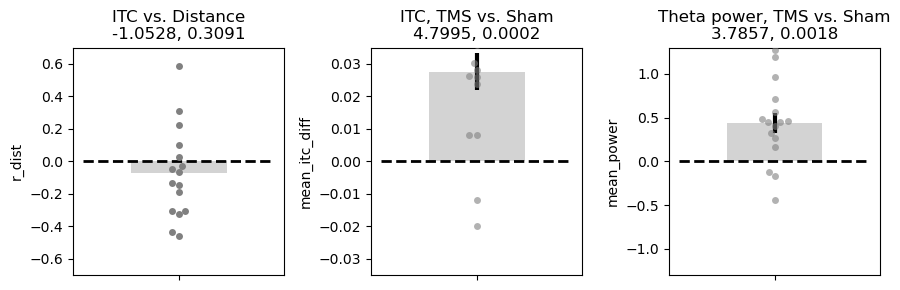

In [7]:
from scipy.stats import sem

# Distance correlations
plt.figure(figsize=(9, 3)); ax=plt.subplot(131)
sns.swarmplot(data=sub_Rs['r_dist'], size=5, alpha=1.0, color='gray')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='--', color='k', linewidth=2)
plt.bar([0], [np.nanmean(sub_Rs['r_dist'])], width=0.5, color='lightgray')
plt.ylim(-0.7, 0.7)
t_, p_ = ttest_1samp(sub_Rs['r_dist'], 0)
plt.title('ITC vs. Distance\n'+str(np.round(t_, 4))+', '+str(np.round(p_, 4)))

# Overall ITC TMS vs sham
ax=plt.subplot(132)
sns.swarmplot(data=sub_Rs['mean_itc_diff'], size=5, alpha=0.6, color='gray')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='--', color='k', linewidth=2)
plt.bar([0], [np.nanmean(sub_Rs['mean_itc_diff'])], width=0.5, color='lightgray', yerr=sem(sub_Rs['mean_itc_diff']), error_kw={'lw':3})
t_, p_ = ttest_1samp(sub_Rs['mean_itc_diff'], 0)
plt.ylim(-0.035, 0.035)
plt.title('ITC, TMS vs. Sham\n'+str(np.round(t_, 4))+', '+str(np.round(p_, 4)))

ax=plt.subplot(133)
sns.swarmplot(data=sub_Rs['mean_power'], size=5, alpha=0.6, color='gray')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='--', color='k', linewidth=2)
plt.bar([0], [np.nanmean(sub_Rs['mean_power'])], width=0.5, color='lightgray', yerr=sem(sub_Rs['mean_power']), error_kw={'lw':3})
t_, p_ = ttest_1samp(sub_Rs['mean_power'], 0)
plt.ylim(-1.3, 1.3)
plt.title('Theta power, TMS vs. Sham\n'+str(np.round(t_, 4))+', '+str(np.round(p_, 4)))

plt.tight_layout()

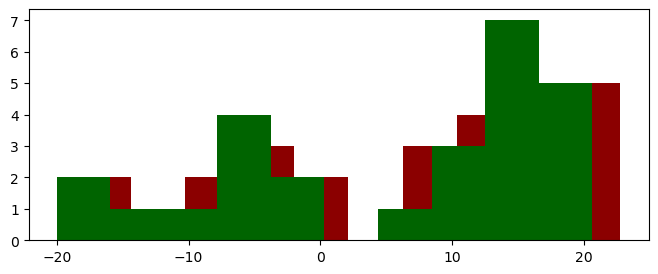

In [34]:
# Plot results
plt.figure(figsize=(8, 3)); plt.subplot(111)

grp = itc_pd.groupby(['subject', 'region']).mean()
grp_clean = itc_pd_clean.groupby(['subject', 'region']).mean()

plt.hist(grp['itc_sum'], color='darkred');
plt.hist(grp_clean['itc_sum'], color='darkgreen');


### MNE-based analysis

In [411]:
from mne.time_frequency import tfr_array_multitaper
from codebase import subject_tfr

# Set parameters
subject = '559'
subroot = 'D:/'+subject+'/'
target = 'DLPFC'

# Load the sham data for an example subject
mytfr = subject_tfr()
mytfr.load_data_epo(subject, target)

Reading D:\559\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
200 matching events found
No baseline correction applied
0 projection items activated


In [200]:
def add_mirror_buffer(data, mirror_size):
    return np.concatenate((np.flip(data[:, :, :mirror_size], axis=2), data, np.flip(data[:, :, -mirror_size:], axis=2)), axis=2)

In [412]:
start_time = 275
end_time = -25

tms_dat = mytfr.epochs['tms'].get_data()[:, :, start_time:end_time]   # don't include any data from the stimulation window
sham_dat = mytfr.epochs['sham'].get_data()[:, :, start_time:end_time]

#Set some params
mirror_size = 225

#Subselect to account for di ffering number of trials
min_trials = np.min([tms_dat.shape[0], sham_dat.shape[0]])
tms_selection = np.random.randint(0, tms_dat.shape[0], size=min_trials); tms_dat = tms_dat[tms_selection, :, :]
sham_selection = np.random.randint(0, sham_dat.shape[0], size=min_trials); sham_dat = sham_dat[sham_selection, :, :]                  

#Add mirror buffers (better than nothing but can induce some spectral changes)
tms_mirror = add_mirror_buffer(tms_dat, mirror_size)  #Using 450ms buffers
sham_mirror = add_mirror_buffer(sham_dat, mirror_size)

# Compute ITC
itc_tms = tfr_array_multitaper(tms_mirror, sfreq=mytfr.fs, freqs=np.arange(3, 9), n_cycles=2, output='itc', n_jobs=n_cpus)
itc_sham = tfr_array_multitaper(sham_mirror, sfreq=mytfr.fs, freqs=np.arange(3, 9), n_cycles=2, output='itc', n_jobs=n_cpus)
itc_tms = np.mean(itc_tms, 1); itc_sham = np.mean(itc_sham, 1);   # Average across frequencies

# Measure and subtract baseline ITC
tms_baseline = mytfr.epochs['tms'].get_data()[:, :, :225]   #leave a 50ms buffer before stimulation window
sham_baseline = mytfr.epochs['sham'].get_data()[:, :, :225]
tms_baseline = tms_baseline[tms_selection, :, :]; sham_baseline = sham_baseline[sham_selection, :, :]  # use the same random sampling as for the full data
tms_baseline_m = add_mirror_buffer(tms_baseline, mirror_size)
sham_baseline_m = add_mirror_buffer(sham_baseline, mirror_size)
itc_tms_base = tfr_array_multitaper(tms_baseline_m, sfreq=mytfr.fs, freqs=np.arange(3, 9), n_cycles=2, output='itc', n_jobs=n_cpus)
itc_sham_base = tfr_array_multitaper(sham_baseline_m, sfreq=mytfr.fs, freqs=np.arange(3, 9), n_cycles=2, output='itc', n_jobs=n_cpus)
itc_tms_base = np.mean(itc_tms_base, 1); itc_sham_base = np.mean(itc_sham_base, 1);  

# Finally, subtract the baseline from the post-stimulation ITCs
itc_tms_bc = itc_tms-np.tile(np.reshape(np.mean(itc_tms_base[:, mirror_size:-mirror_size], axis=1), (-1, 1)), (1, itc_tms.shape[1]))
itc_sham_bc = itc_sham-np.tile(np.reshape(np.mean(itc_sham_base[:, mirror_size:-mirror_size], axis=1), (-1, 1)), (1, itc_sham.shape[1]))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  67 out of  67 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  67 out of  67 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  67 out of  67 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  67 out of  67 | elapsed:    0.4s finished


Mirror buffer can remove stim artifact from spectral analysis but introduces its own distortion to measured IPC -- though expect results to be reasonably close (0-25% off, give or take) 

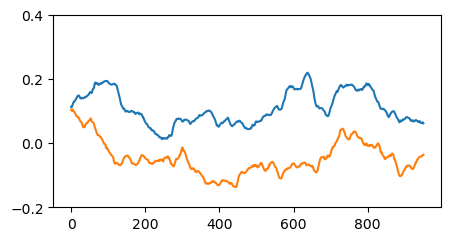

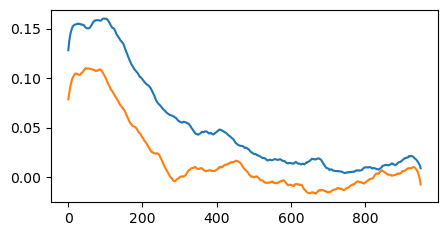

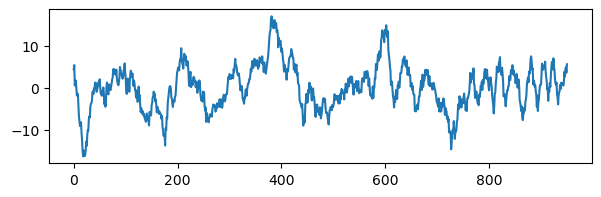

In [421]:
i = 46

plt.figure(figsize=(5, 2.5)); ax=plt.subplot(111)
plt.plot(itc_tms_bc[i, 225:-225])
plt.plot(itc_sham_bc[i, 225:-225])
plt.ylim(-0.2, 0.4)

plt.figure(figsize=(5, 2.5)); ax=plt.subplot(111)
plt.plot(np.mean(itc_tms_bc[:, 225:-225], 0))
plt.plot(np.mean(itc_sham_bc[:, 225:-225], 0))

plt.figure(figsize=(7, 2)); ax=plt.subplot(111)
plt.plot(tms_dat[5, i, :]) 

Find a good example of ERP phase-locking and sustained phase-locking (e.g. possible phase reset phenomenon)

<BarContainer object of 67 artists>

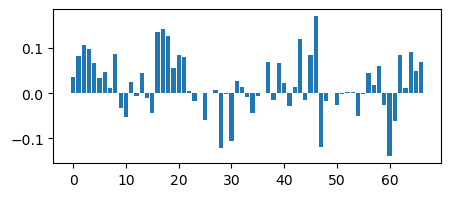

In [414]:
diff = itc_tms_bc[:, mirror_size:-mirror_size]-itc_sham_bc[:, mirror_size:-mirror_size]

# Find the mean ITC difference in a late window -- sample 400 would be 800ms post-stim
mean_diff = np.mean(diff[:, 400:], 1)

# Plot results
plt.figure(figsize=(5, 2)); ax=plt.subplot(111)
plt.bar(np.arange(len(mean_diff)), mean_diff)

### Legacy code

In [ ]:
import pycircstat as circ
import os

# Set up parameters
freqs = [3, 4, 5, 6, 7, 8]  # theta
#freqs = np.arange(30, 51, 2) # gamma
fs = 500   # 500Hz sampling

for sub in list(good_subs.keys())[:]:
    for sess in good_subs[sub][:]:
        
        try:
            os.mkdir('./TMSEEG_data/'+sub+'/PLV')
        except:
            pass

        # Load the data
        tms_dat = np.load('./TMSEEG_data/'+sub+'/'+sub+'_TMS_'+sess+'_0_5Hz_1-CleanedFilteredSubsampled.npy')  # using the -0.5 to 2 second files
        sham_dat = np.load('./TMSEEG_data/'+sub+'/'+sub+'_Sham_'+sess+'_0_5Hz_1-CleanedFilteredSubsampled.npy')  # file is trials x elecs x samples 

        # Get TFR of phase from the TMS trials
        tfr_tms = mne.time_frequency.tfr_array_multitaper(tms_dat[:, :, :], 
                                                          sfreq=fs, freqs=freqs, output='phase',
                                                          n_cycles=3, n_jobs=n_cpus)

        # Now for the sham trials
        tfr_sham = mne.time_frequency.tfr_array_multitaper(sham_dat[:, :, :],
                                                           sfreq=fs, freqs=freqs, output='phase',
                                                          n_cycles=3, n_jobs=n_cpus)  # output is trials x elecs x tapers x frequencies x times

        tfr_tms = circ.mean(tfr_tms, axis=2)  #Average phase across tapers
        tfr_sham = circ.mean(tfr_sham, axis=2)

        # Generate null distribution
        null_diffs = get_null_distribution(tfr_tms, tfr_sham)

        # Compute phase locking and TMS vs sham difference
        rlv_tms = circ.resultant_vector_length(tfr_tms, axis=0)
        rlv_sham = circ.resultant_vector_length(tfr_sham, axis=0)
        tru_diff = rlv_tms-rlv_sham
        tru_diff = np.mean(tru_diff, axis=1)  # average over frequencies

        # Epoch into 100ms windows
        winsize = int(0.1*fs)
        tru_diff_epoch = np.mean(np.reshape(tru_diff, (tru_diff.shape[0], winsize, -1), order='F'), axis=1)
        null_diffs_epoch = np.mean(np.reshape(null_diffs, (null_diffs.shape[0], null_diffs.shape[1], winsize, -1), order='F'), 2)

        # Average z-score in the window of interest
        start_win = 11; end_win = start_win+9
        tru_diff_win = np.mean(tru_diff_epoch[:, start_win:end_win], 1)
        null_diffs_win = np.mean(null_diffs_epoch[:, :, start_win:end_win], 2)
        z_win = (tru_diff_win-np.mean(null_diffs_win, 0))/np.std(null_diffs_win, 0)
        
        # Save results!
        # np.save('./TMSEEG_data/'+sub+'/PLV/'+sub+'_'+sess+'_'+'ITC_Z_1p1sec_2p0sec.npy', z_win)
        # np.save('./TMSEEG_data/'+sub+'/PLV/'+sub+'_'+sess+'_'+'ITC_nulls.npy', null_diffs_epoch)
        # np.save('./TMSEEG_data/'+sub+'/PLV/'+sub+'_'+sess+'_'+'ITC_true.npy', tru_diff_epoch)